<a href="https://colab.research.google.com/github/chwdoit/BigData/blob/main/%EC%84%B1%EC%9D%B8_%EC%9D%B8%EA%B5%AC%EC%A1%B0%EC%82%AC_%EC%86%8C%EB%93%9D_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
!pip install catboost

In [ ]:
# 데이터셋 : https://www.kaggle.com/competitions/kakr-4th-competition
# 분석
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (8, 6)


# 모델링
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# 스코어링
from sklearn.metrics import f1_score
from sklearn.metrics import *


import warnings
warnings.filterwarnings('ignore')

# random_state
seed = 3

# Load Data & Check

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
submission = pd.read_csv("/content/sample_submission.csv")

print('train shape: ', train.shape)
print('test shape: ', test.shape)
print('submission shape: ', submission.shape)

train shape:  (26049, 16)
test shape:  (6512, 15)
submission shape:  (6512, 2)


In [ ]:
train.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K
1,1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,<=50K
2,2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,<=50K
3,3,21,Private,151158,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,<=50K
4,4,24,Private,122234,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,<=50K


* `id`
* `age`: 나이
* `workclass`: 고용 형태
* `fnlwgt`: 사람 대표성을 나타내는 가중치 (final weight의 약자)
* `education`: 교육 수준
* `education_num`: 교육 수준 수치
* `marital_status`: 결혼 상태
* `occupation`: 업종
* `relationship`: 가족 관계
* `race`: 인종
* `sex`: 성별
* `capital_gain`: 양도 소득
* `capital_loss`: 양도 손실
* `hours_per_week`: 주당 근무 시간
* `native_country`: 국적
* `income`: 수익 (예측해야 하는 값)
    * `>50K`: 1
    * `<=50K`: 0

In [ ]:
# EDA와 Feature Engineering을 위해서는 복사한 데이터를 사용하는 것이 좋다.
tmp_train = train.copy()

In [ ]:
# 대략적인 데이터 살펴보기
tmp_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26049 entries, 0 to 26048
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              26049 non-null  int64 
 1   age             26049 non-null  int64 
 2   workclass       26049 non-null  object
 3   fnlwgt          26049 non-null  int64 
 4   education       26049 non-null  object
 5   education_num   26049 non-null  int64 
 6   marital_status  26049 non-null  object
 7   occupation      26049 non-null  object
 8   relationship    26049 non-null  object
 9   race            26049 non-null  object
 10  sex             26049 non-null  object
 11  capital_gain    26049 non-null  int64 
 12  capital_loss    26049 non-null  int64 
 13  hours_per_week  26049 non-null  int64 
 14  native_country  26049 non-null  object
 15  income          26049 non-null  object
dtypes: int64(7), object(9)
memory usage: 3.2+ MB


* `id`, `age`, `fnlwgt`, `education_num`, `capital_gain`, `capital_loss`, `hour_per_week`가 int값이며 다른 변수는 object 즉, string 형태이다.
* 데이터에 null 값이 없다고 나와있지만, eda를 진행하다보면 `workclass`, `occupation`, `native_country`에는 '?'라고 하는 결측치가 있다.

# EDA (Exploratory Data Analysis)

## Target Check

In [ ]:
# 변수명 처리
tmp_train['income'] = tmp_train['income'].map(lambda x: 1 if x=='>50K' else 0)

In [ ]:
tmp_train['income'].value_counts()

0    19744
1     6305
Name: income, dtype: int64

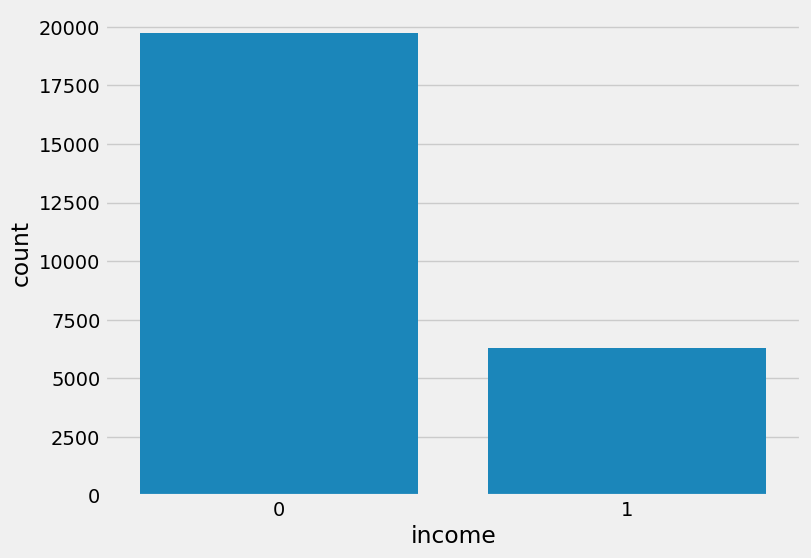

In [ ]:
sns.countplot(x='income', data=tmp_train);

데이터가 굉장히 Unbalance 할 경우에 Oversampling/Undersampling을 고려해야 하는데 이 대회의 경우 25% 정도의 데이터를 가지고 있기 때문에 그런 문제에 대해서는 고려하지 않아도 된다.

### fnlwgt

* 변수에 대한 설명 - (https://www.kaggle.com/c/kakr-4th-competition/discussion/191173)
* 전체 변수에 따른 가중치라고 한다. (e.g., 대졸이고, 결혼했고,,... 이러면 fnlwgt가 높음)
* Target에 따라 큰 차이가 없음 -> Feature Engineering 없이 그대로 사용

* (결과) 성별, 교육 수준 등이 반영한 변수기 때문에 Feature Importance는 높게 나왔다.

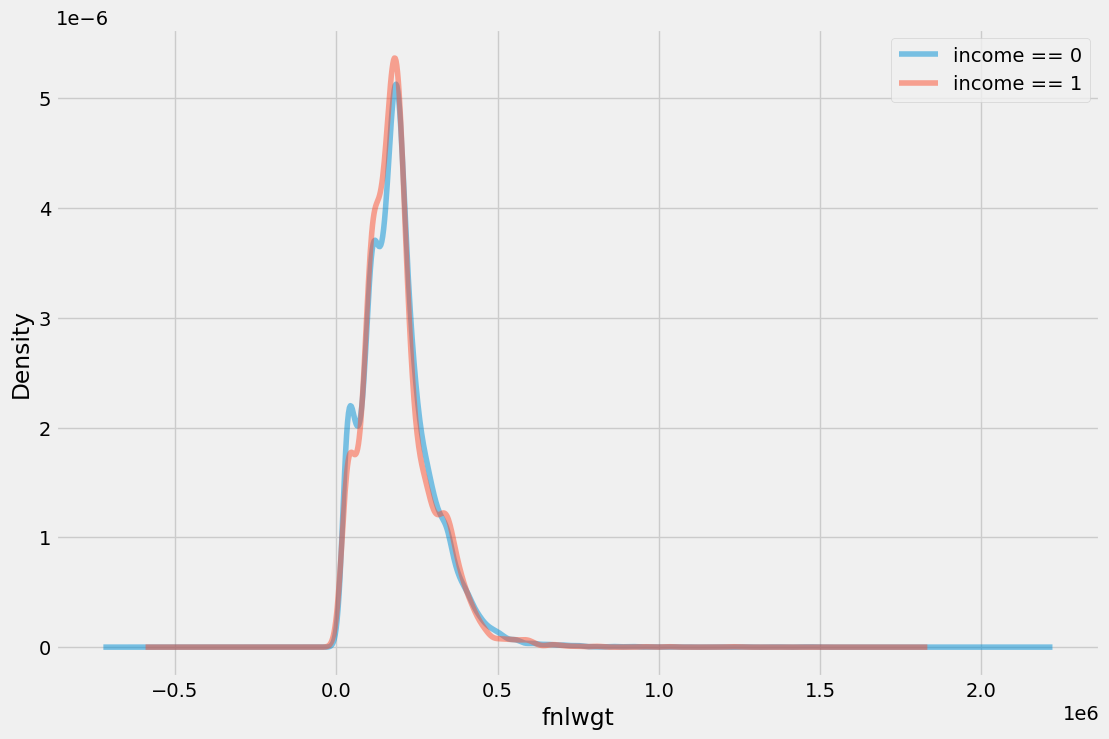

In [ ]:
plt.figure(figsize=(12, 8))

tmp_train.loc[tmp_train['income'] == 0, 'fnlwgt'].plot(kind='kde', alpha=0.5, label='income == 0')
tmp_train.loc[tmp_train['income'] == 1, 'fnlwgt'].plot(kind='kde', alpha=0.5, label='income == 1')

plt.legend()
plt.xlabel('fnlwgt')
plt.show()

### age

* 낮은 연령대에서는 Target이 0, 높은 연령대에서는 Target이 1인 경향을 보인다.
* Titanic 대회처럼 `age_band` 변수를 만들어 연령대 범위를 나눠서 적용해봤지만 그대로 사용할 때 Feature Importance가 높게 나왔다.

In [ ]:
print('최소 연령: ', tmp_train['age'].min())
print('최고 연령: ', tmp_train['age'].max())
print('평균 연령: {:.2f}'.format(tmp_train['age'].mean()))

최소 연령:  17
최고 연령:  90
평균 연령: 38.57


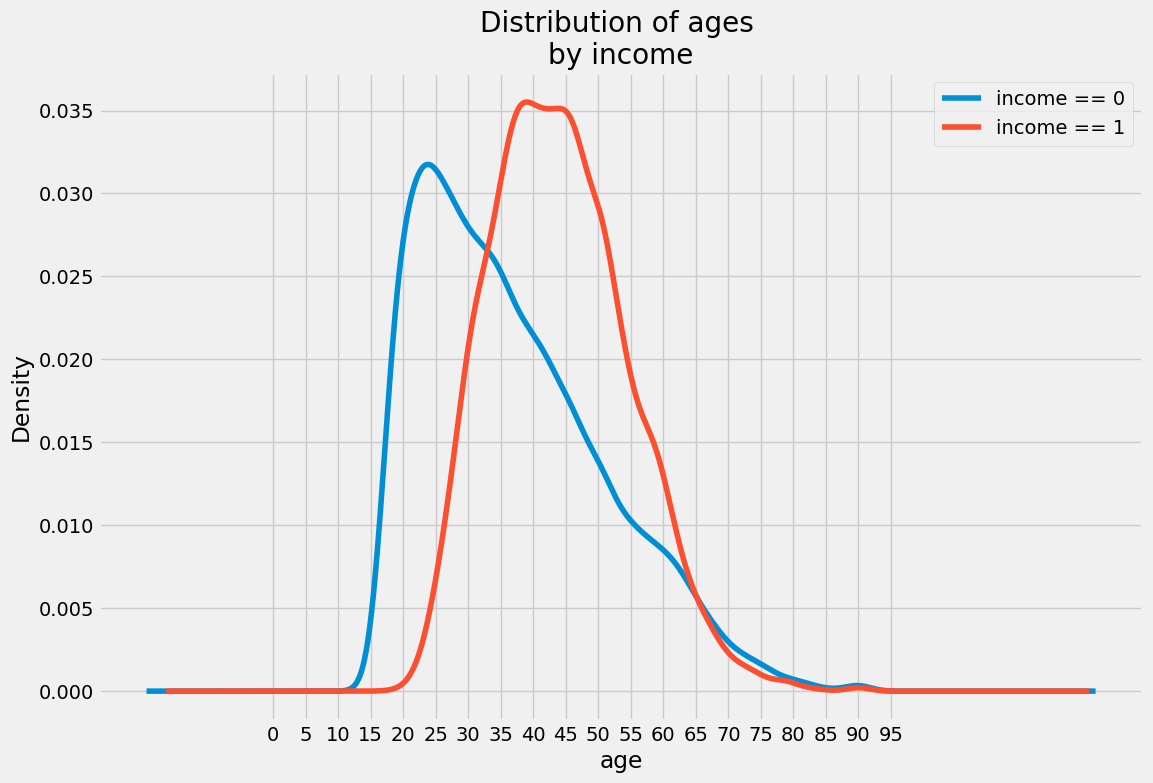

In [ ]:
# 소득에 따른 연령 구분

plt.figure(figsize=(12, 8))

tmp_train.loc[tmp_train['income'] == 0, 'age'].plot(kind='kde', label='income == 0')
tmp_train.loc[tmp_train['income'] == 1, 'age'].plot(kind='kde', label='income == 1')

plt.title('Distribution of ages \nby income')
plt.xticks(range(0, 100, 5))
plt.xlabel('age')
plt.legend()
plt.show()

In [ ]:
def make_age_band(df):
    df['age_band'] = 0
    df.loc[df['age'] < 20, 'age_band'] = 10
    df.loc[(df['age'] >= 20) & (df['age'] < 30), 'age_band'] = 20
    df.loc[(df['age'] >= 30) & (df['age'] < 40), 'age_band'] = 30
    df.loc[(df['age'] >= 40) & (df['age'] < 50), 'age_band'] = 40
    df.loc[(df['age'] >= 50) & (df['age'] < 60), 'age_band'] = 50
    df.loc[(df['age'] >= 60) & (df['age'] < 70), 'age_band'] = 60
    df.loc[(df['age'] >= 70) & (df['age'] < 80), 'age_band'] = 70
    df.loc[(df['age'] >= 80) & (df['age'] < 90), 'age_band'] = 80
    df.loc[(df['age'] >= 90), 'age_band'] = 90

    return df

tmp_train = make_age_band(tmp_train)

In [ ]:
# 결과 확인
tmp_train['age_band'].value_counts().sort_index()

10    1321
20    6489
30    6878
40    5726
50    3494
60    1627
70     411
80      67
90      36
Name: age_band, dtype: int64

### capital_gain & capital_los (양도 소득, 양도 손실)

분포가 특이해보인다.

* **capital_gain**(양도 소득)이란
    * 개인이 토지, 건물 등 부동산이나 주식 등과 파생상품의 양도 또는 분양권과 같은 부동산에 관한 권리를 양도함으로 인하여 발생하는 이익(소득)을 과세대상으로 하여 부과하는 세금
    
* **capital_loss**(양도 손실)
    * 투자 또는 부동산과 같은 자본 자산의 가치가 감소할 때 발생하는 손실
    
* 양도 소득, 손실이 있고, 없고로 구분해서(0, 1) 모델을 세워봤지만 결과가 안좋았다. (데이터를 단순화 시켜서 그런듯함)

* capital 값이 있는 사람의 경우 `capital_gain` 또는 `capital_loss`에만 값이 있었다. -> 확인

* `capital_log` 변수를 만들어 각 변수의 로그 값에 gain/loss에 따라 부호를 취함


* **최종적으로는 `capital_log`라는 변수를 만들었다. 두 변수를 로그 변환 시킨 뒤 `capital_loss`는 음수처리를 하여 합쳤다.**

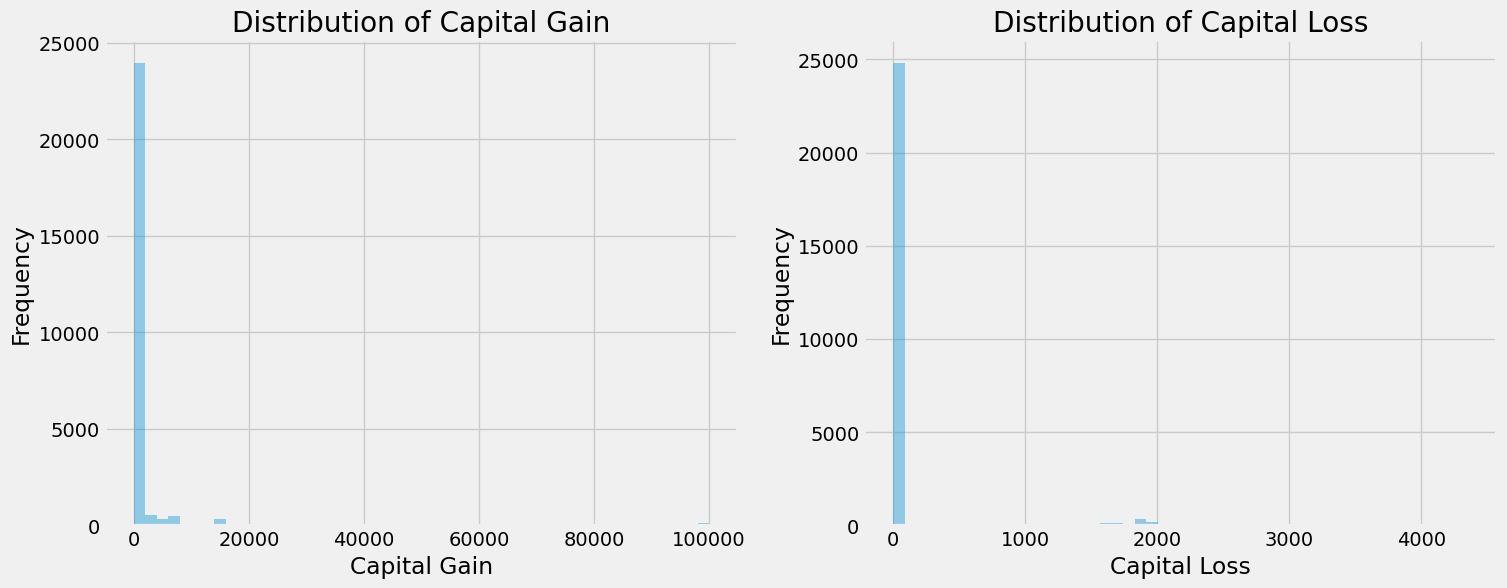

In [ ]:
# capital_gain과 capital_loss의 값 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Capital Gain
sns.distplot(tmp_train['capital_gain'], kde=False, ax=axes[0])
axes[0].set_title('Distribution of Capital Gain')
axes[0].set_xlabel('Capital Gain')
axes[0].set_ylabel('Frequency')

# Capital Loss
sns.distplot(tmp_train['capital_loss'], kde=False, ax=axes[1])
axes[1].set_title('Distribution of Capital Loss')
axes[1].set_xlabel('Capital Loss')
axes[1].set_ylabel('Frequency')

plt.show()


값의 분포가 매우 커보여 0인 데이터와 아닌 데이터로 확인을 진행했다.

In [ ]:
# capital_gain과 capital_loss 값이 0이 아닌 데이터 확인

capital_gain_value = tmp_train.loc[tmp_train['capital_gain'] != 0, 'capital_gain']
capital_loss_value = tmp_train.loc[tmp_train['capital_loss'] != 0, 'capital_loss']

print('capital_gain: {}\t{:.2f}%'.format(len(capital_gain_value), len(capital_gain_value) / len(tmp_train) * 100))
print('capital_loss: {}\t{:.2f}%'.format(len(capital_gain_value), len(capital_loss_value) / len(tmp_train) * 100))

capital_gain: 2193	8.42%
capital_loss: 2193	4.71%


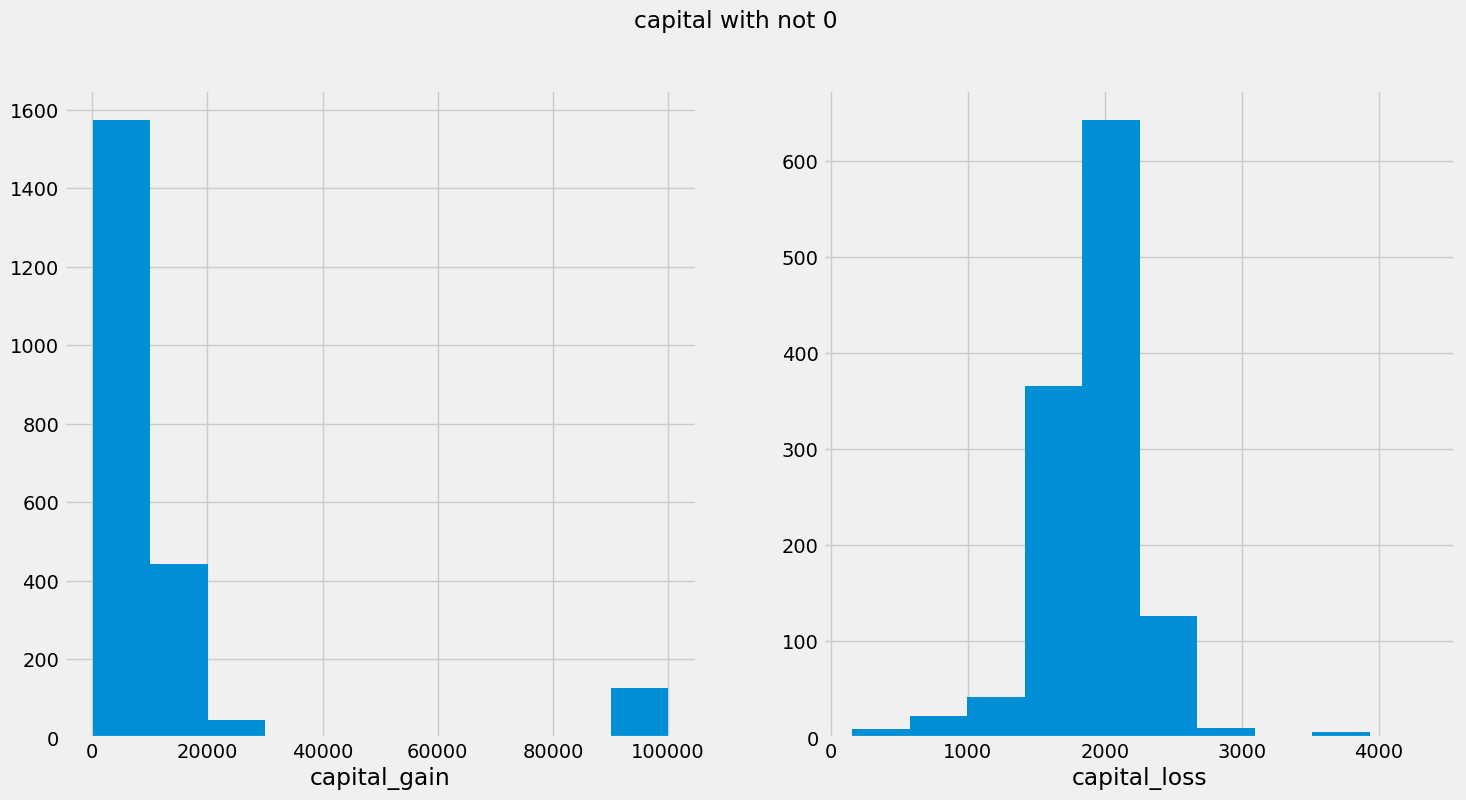

In [ ]:
# 0이 아닌 값에 대한 분포 확인

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
plt.suptitle('capital with not 0')

tmp_train.loc[tmp_train['capital_gain'] != 0, 'capital_gain'].plot(kind='hist', ax=ax[0])
ax[0].set_xlabel('capital_gain'); ax[0].set_ylabel('')

tmp_train.loc[tmp_train['capital_loss'] != 0, 'capital_loss'].plot(kind='hist', ax=ax[1])
ax[1].set_xlabel('capital_loss'); ax[1].set_ylabel('')

plt.show()

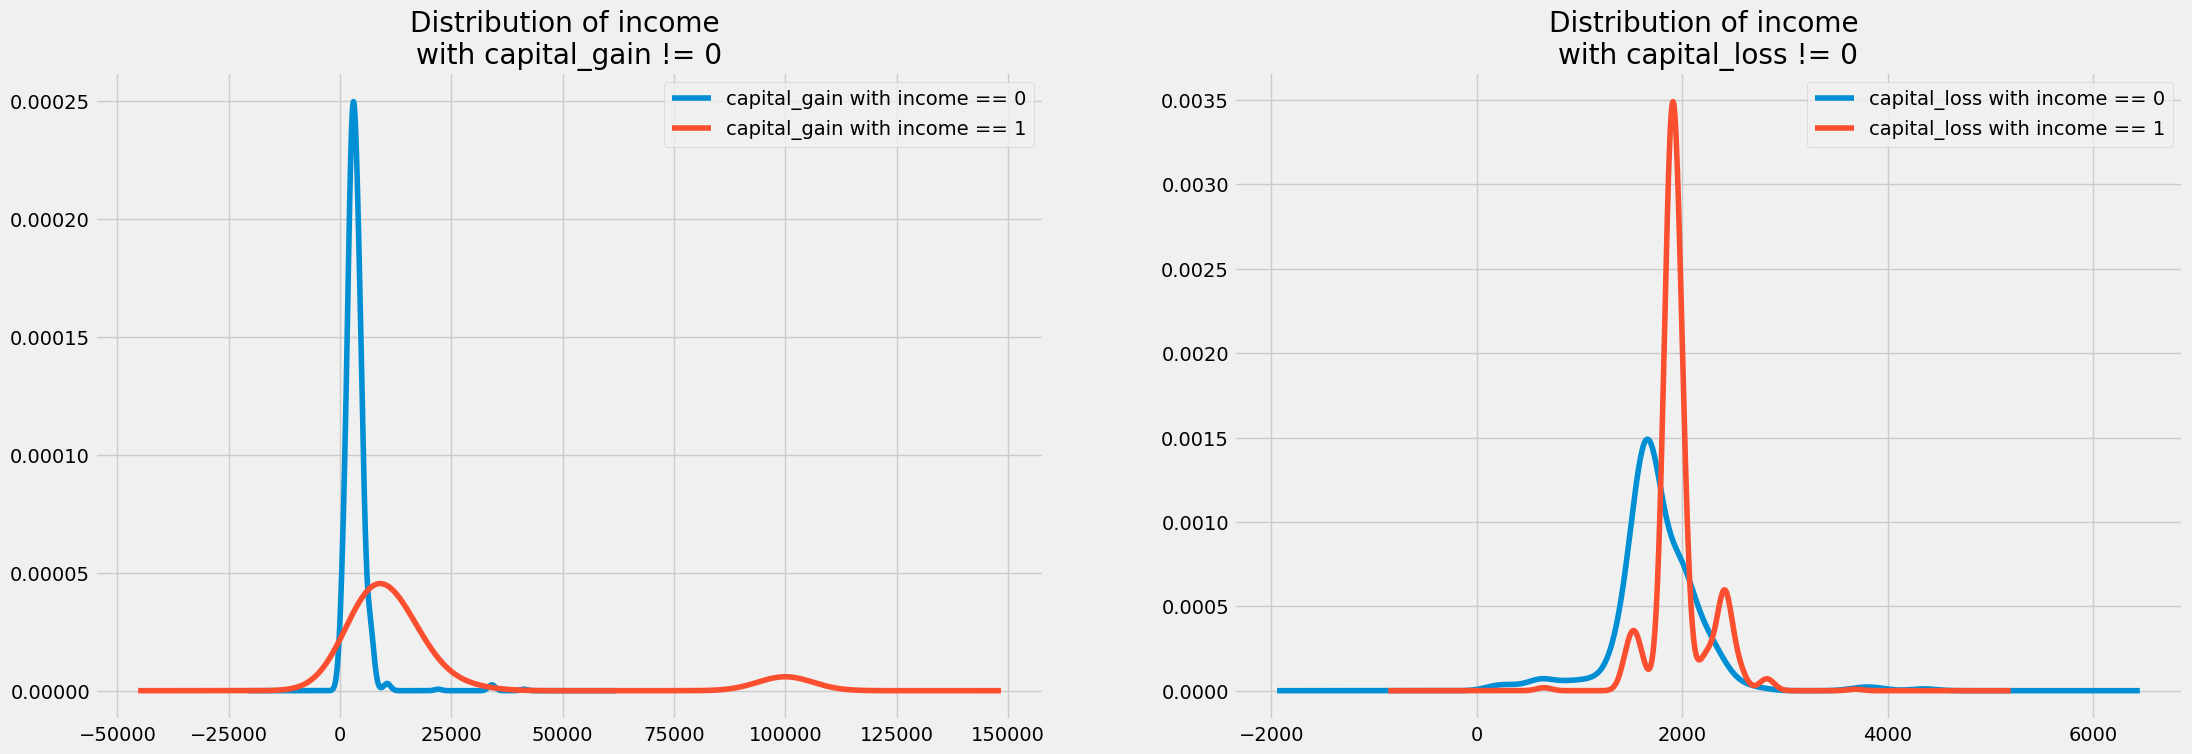

In [ ]:
# 0이 아닌 데이터에 대하여 타겟에 따른 분포 확인

fig, ax = plt.subplots(1, 2, figsize=(24, 8))

# capital_gain이 0이 아닌 데이터에 대한 income 비교
tmp_train.loc[(tmp_train['capital_gain'] != 0) & (tmp_train['income'] == 0), 'capital_gain'].plot(kind='kde', label='capital_gain with income == 0', ax=ax[0])
tmp_train.loc[(tmp_train['capital_gain'] != 0) & (tmp_train['income'] == 1), 'capital_gain'].plot(kind='kde', label='capital_gain with income == 1', ax=ax[0])

ax[0].set_title('Distribution of income \nwith capital_gain != 0')
ax[0].set_ylabel('')
ax[0].legend()


# capital_loss가 0이 아닌 데이터에 대한 income 비교
tmp_train.loc[(tmp_train['capital_loss'] != 0) & (tmp_train['income'] == 0), 'capital_loss'].plot(kind='kde', label='capital_loss with income == 0', ax=ax[1])
tmp_train.loc[(tmp_train['capital_loss'] != 0) & (tmp_train['income'] == 1), 'capital_loss'].plot(kind='kde', label='capital_loss with income == 1', ax=ax[1])

ax[1].set_title('Distribution of income \nwith capital_loss != 0')
ax[1].set_ylabel('')
ax[1].legend()

plt.show()

In [ ]:
# 0이 아닌 값에 대하여 데이터가 capital_gain과 capital_loss가 한쪽에만 존재하는지 확인
tmp_train[(tmp_train['capital_gain'] != 0) & (tmp_train['capital_loss'] != 0)]

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,age_band


In [ ]:
# 데이터 변환

# 각 변수의 로그 변수 생성
tmp_train['capital_gain_log'] = 0
tmp_train['capital_loss_log'] = 0

# log값 구하기
tmp_train['capital_gain_log'] = tmp_train['capital_gain'].map(lambda x: np.log1p(x))
tmp_train['capital_loss_log'] = tmp_train['capital_loss'].map(lambda x: (-1) * np.log1p(x)) # loss는 음수로 처리


# capital_log 변수 생성
tmp_train['capital_log'] = 0

# capital_loss_log에는 음수 값으로 적용해준다
tmp_train['capital_log'] = tmp_train['capital_gain_log'] + tmp_train['capital_loss_log']

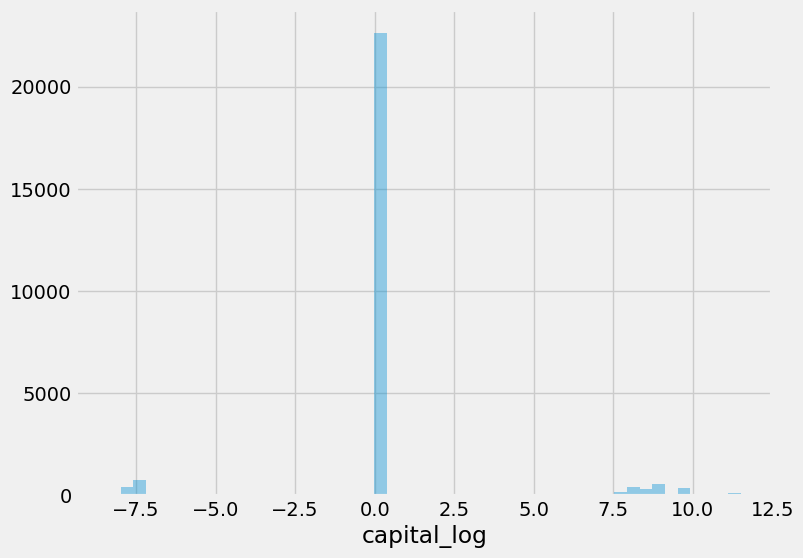

In [ ]:
# 분포 확인
sns.distplot(tmp_train['capital_log'], kde=False);

In [ ]:
# log 데이터 삭제
tmp_train = tmp_train.drop(columns=['capital_gain_log', 'capital_loss_log'])

### education & education_num

* `education` 과 `education_num`은 같은 의미를 가진다. -> 하나의 변수만 남김
* `education_num`을 날리고 `education`은 남겨뒀다. (후에 LabelEncoding을 적용하더라고 EDA시 다른 변수와의 의미를 확인하기 위함)
* Feature Engineering을 적용해야 할 근거를 찾지 못함 -> **그대로 사용**

In [ ]:
tmp_train[['education', 'education_num']].value_counts()

education     education_num
HS-grad       9                8433
Some-college  10               5800
Bachelors     13               4344
Masters       14               1378
Assoc-voc     11               1096
11th          7                 922
Assoc-acdm    12                842
10th          6                 731
7th-8th       4                 505
Prof-school   15                466
9th           5                 418
12th          8                 359
Doctorate     16                316
5th-6th       3                 265
1st-4th       2                 134
Preschool     1                  40
dtype: int64

In [ ]:
# education_num 삭제
tmp_train = tmp_train.drop('education_num', axis=1)

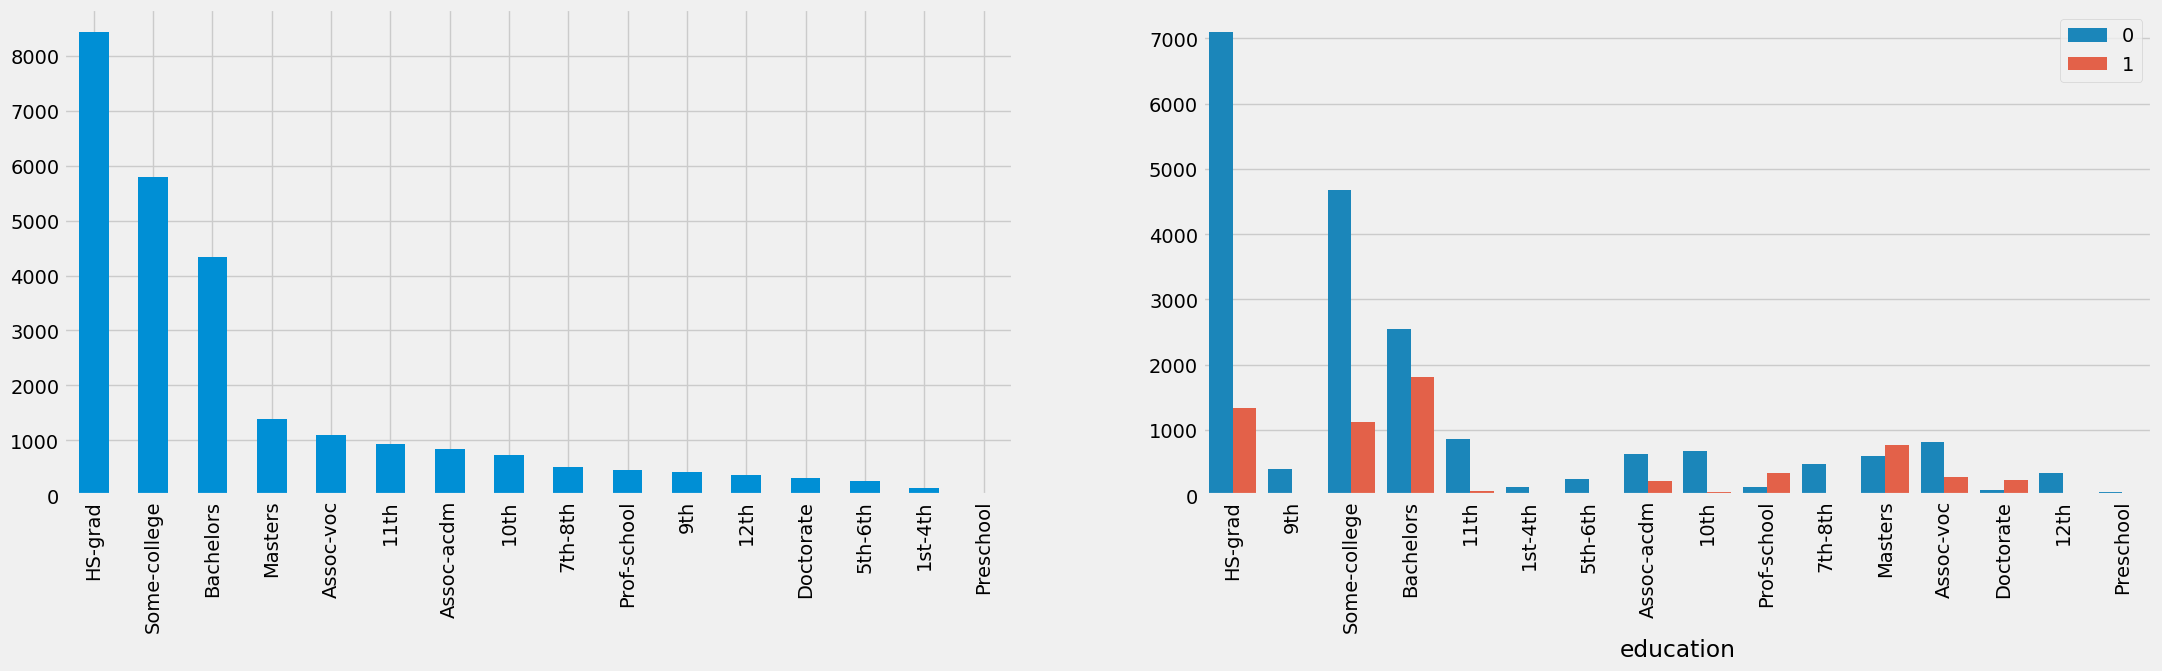

In [ ]:
# education 분포 확인
fig, ax = plt.subplots(1, 2, figsize=(24, 6))

tmp_train['education'].value_counts().plot(kind='bar', ax=ax[0])

# 타겟에 따른 분포 확인
sns.countplot(x='education', hue='income', data=tmp_train, ax=ax[1])
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].legend(loc='upper right')
ax[1].set_ylabel('')

plt.show()

### marital_status & relationship

* 둘 다 결혼에 관한 데이터를 의미한다.
* 비슷한 의미를 가지니 아예 합쳐서 사용하자 -> 두 개의 변수를 삭제하고 임의로 하나의 변수를 만든 결과 모델 성능이 더 안좋아졌다. (잘 모르겠는 경우 웬만하면 데이터를 그대로 사용하는 것이 좋은 결과가 나온다.)

In [ ]:
train['marital_status'].value_counts()

Married-civ-spouse       11970
Never-married             8568
Divorced                  3536
Separated                  826
Widowed                    796
Married-spouse-absent      334
Married-AF-spouse           19
Name: marital_status, dtype: int64

In [ ]:
train['relationship'].value_counts()

Husband           10541
Not-in-family      6632
Own-child          4099
Unmarried          2740
Wife               1260
Other-relative      777
Name: relationship, dtype: int64

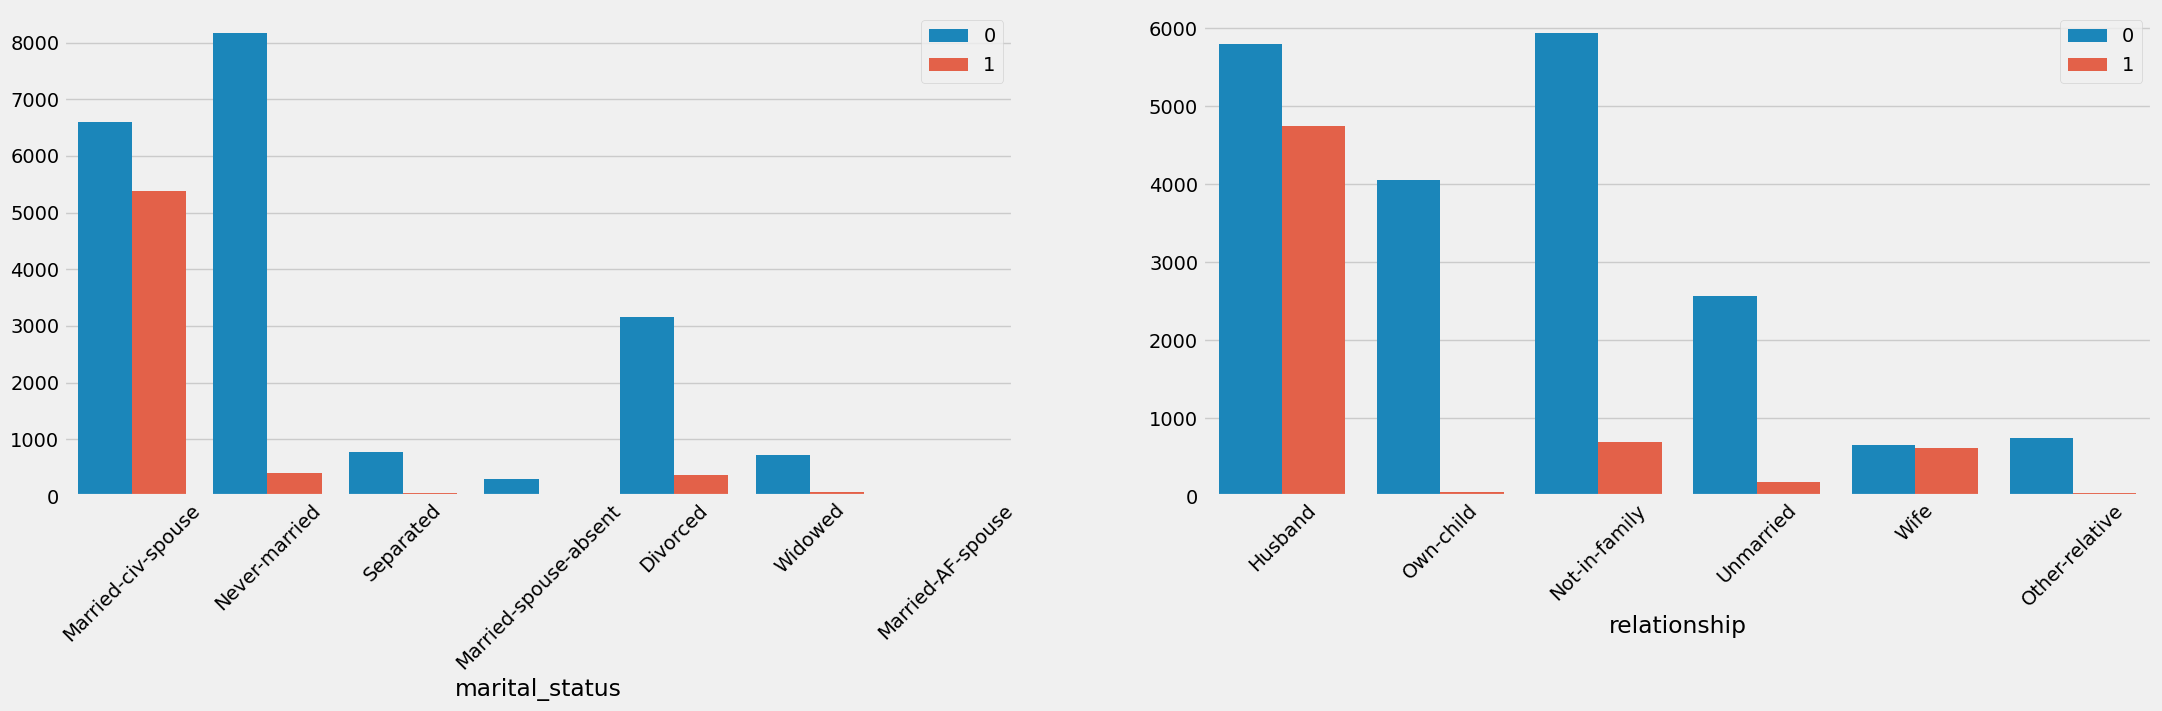

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))

sns.countplot(x='marital_status', hue='income', data=tmp_train, ax=ax[0])
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].legend()
ax[0].set_ylabel('')

sns.countplot(x='relationship', hue='income', data=tmp_train, ax=ax[1])
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].legend()
ax[1].set_ylabel('')

plt.show()

### race & native_country

* `race`는 신경을 안써도 되지만, `native_country`는 변수가 너무 많고 United-States`에 편중되어 있어 0과 1로 나눠서 적용했다. (`native_country`의 경우 그대로 사용하거나 0,1로 변환해서 사용했을 때 모두 Feature Imortance가 가장 낮게 나왔다.)

In [ ]:
tmp_train['race'].value_counts()

White                 22315
Black                  2476
Asian-Pac-Islander      800
Amer-Indian-Eskimo      254
Other                   204
Name: race, dtype: int64

In [ ]:
tmp_train['native_country'].value_counts()

United-States                 23371
Mexico                          534
?                               456
Philippines                     163
Germany                         101
Puerto-Rico                      95
Canada                           92
El-Salvador                      79
India                            77
Cuba                             76
England                          67
Jamaica                          64
South                            63
China                            57
Guatemala                        52
Columbia                         52
Italy                            50
Vietnam                          50
Dominican-Republic               48
Poland                           47
Japan                            47
Taiwan                           39
Haiti                            35
Iran                             35
Portugal                         30
Nicaragua                        28
Peru                             26
Ecuador                     

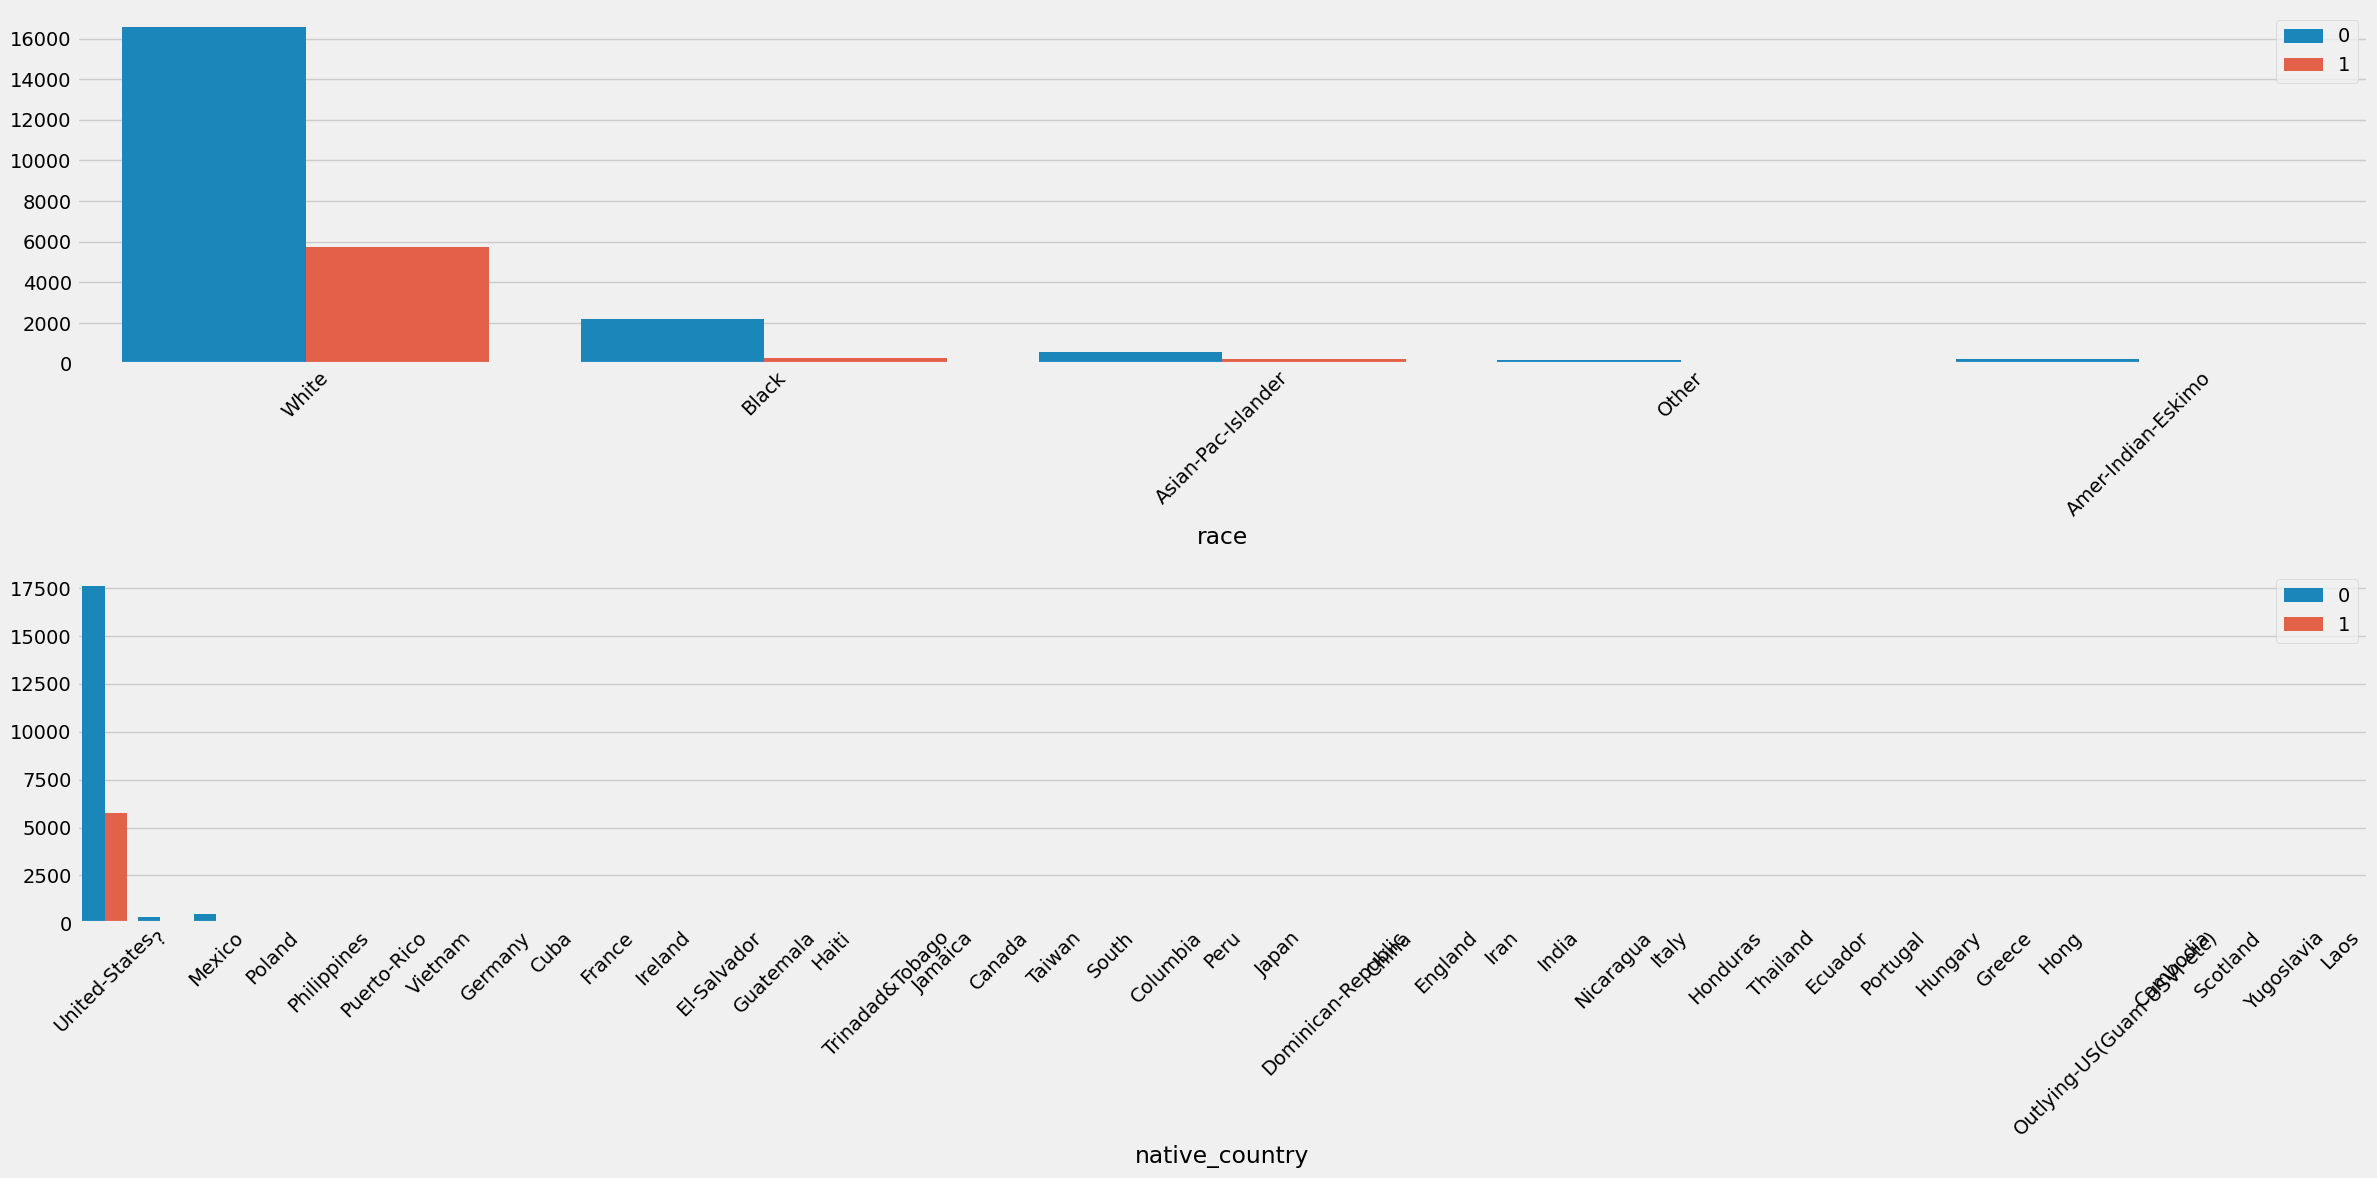

In [ ]:
# 2x1 서브플롯 그리드 생성
fig, ax = plt.subplots(2, 1, figsize=(24, 12))

# 첫 번째 서브플롯 (위쪽)
sns.countplot(x='race', hue='income', data=tmp_train, ax=ax[0])
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].legend()
ax[0].set_ylabel('')

# 두 번째 서브플롯 (아래쪽)
sns.countplot(x='native_country', hue='income', data=tmp_train, ax=ax[1])
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].legend()
ax[1].set_ylabel('')

plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()

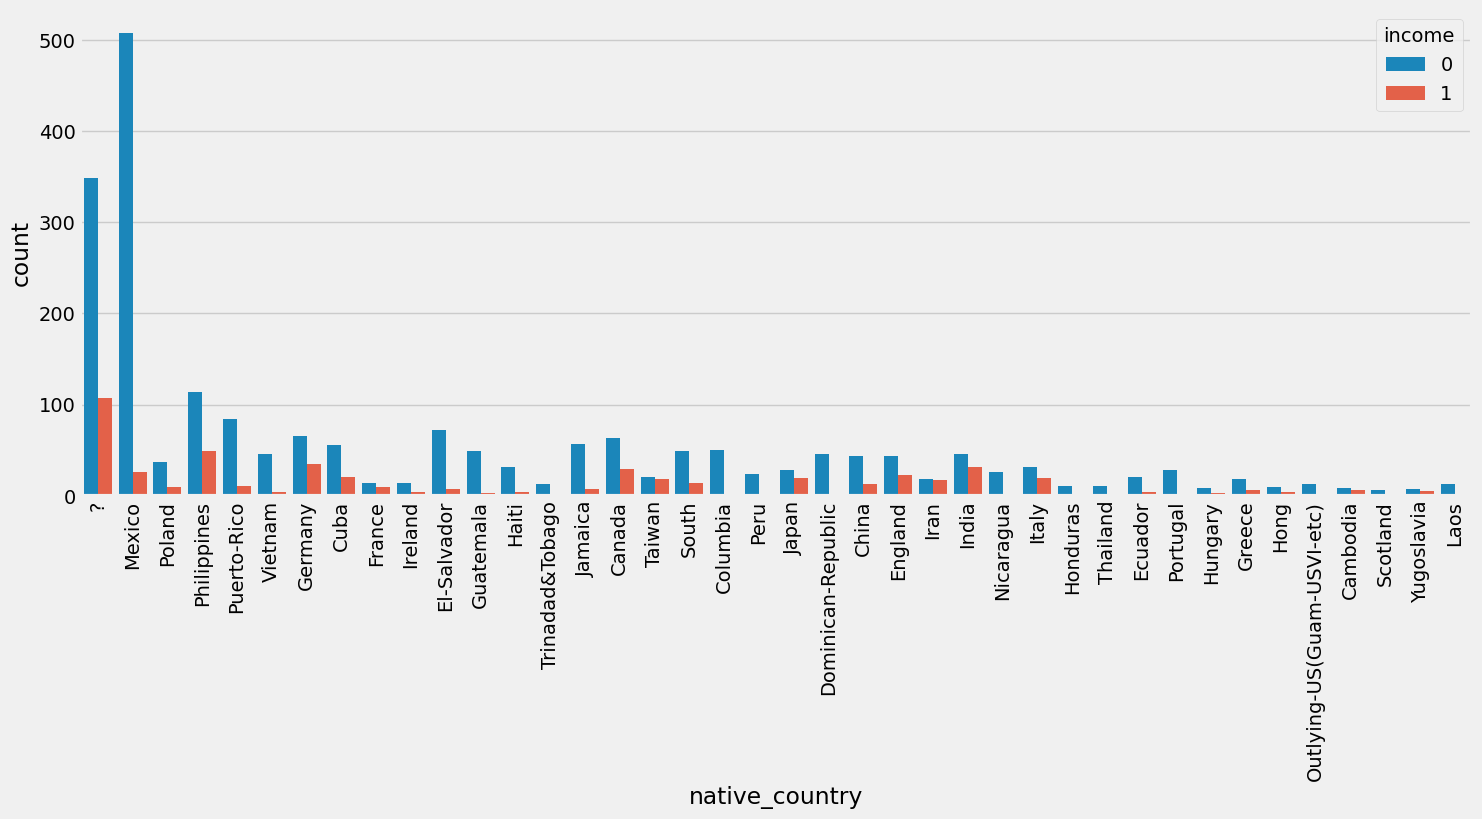

In [ ]:
# native_country에서 United-States가 아닌 국가 확인
# 값이 너무 작다
# 그래프의 가로 크기를 조정하여 countplot 생성
plt.figure(figsize=(16, 6))
sns.countplot(x='native_country', hue='income', data=tmp_train[tmp_train['native_country'] != 'United-States'])
plt.xticks(rotation=90)  # x축 레이블 회전
plt.show()

In [ ]:
# native_country 값 변경
tmp_train['native_country_bin'] = tmp_train['native_country'].map(lambda x: 1 if x == 'United-States' else 0)

In [ ]:
tmp_train['native_country_bin'].value_counts()

1    23371
0     2678
Name: native_country_bin, dtype: int64

### workclass & occupation

* '?'라고 하는 결측치로 보이는 값이 존재했고, 이 변수를 처리하는 것이 가장 큰 문제였다. (결국은 제대로 처리하지 못했다.)
* `occupation`이 `workclass`보다 '?' 값이 6개가 더 많았고, 해당 값을 확인해본 결과 `workclass`의 Never-worked 값과 일치되었기 때문에 해당 값으로 처리를 하였다.
* 남은 '?' 값에 대해서는 다른 처리를 진행하지 않고 그대로 사용했다.
* 최빈값 처리, box-plot(`hours_per_week`) 에서 유사한 형태를 보이는 값으로 수정도 해봤지만 정확한 근거가 없이 추측이었고, 꽤 많은 '?' 값을 해당 값으로 바꾼 것이기 때문에 결과는 더욱 안좋아졌다.

In [ ]:
tmp_train['workclass'].value_counts()

Private             18123
Self-emp-not-inc     2030
Local-gov            1692
?                    1502
State-gov            1043
Self-emp-inc          877
Federal-gov           765
Without-pay            11
Never-worked            6
Name: workclass, dtype: int64

In [ ]:
tmp_train['occupation'].value_counts()

Prof-specialty       3304
Craft-repair         3262
Exec-managerial      3246
Sales                2998
Adm-clerical         2983
Other-service        2626
Machine-op-inspct    1582
?                    1508
Transport-moving     1270
Handlers-cleaners    1092
Farming-fishing       784
Tech-support          742
Protective-serv       522
Priv-house-serv       123
Armed-Forces            7
Name: occupation, dtype: int64

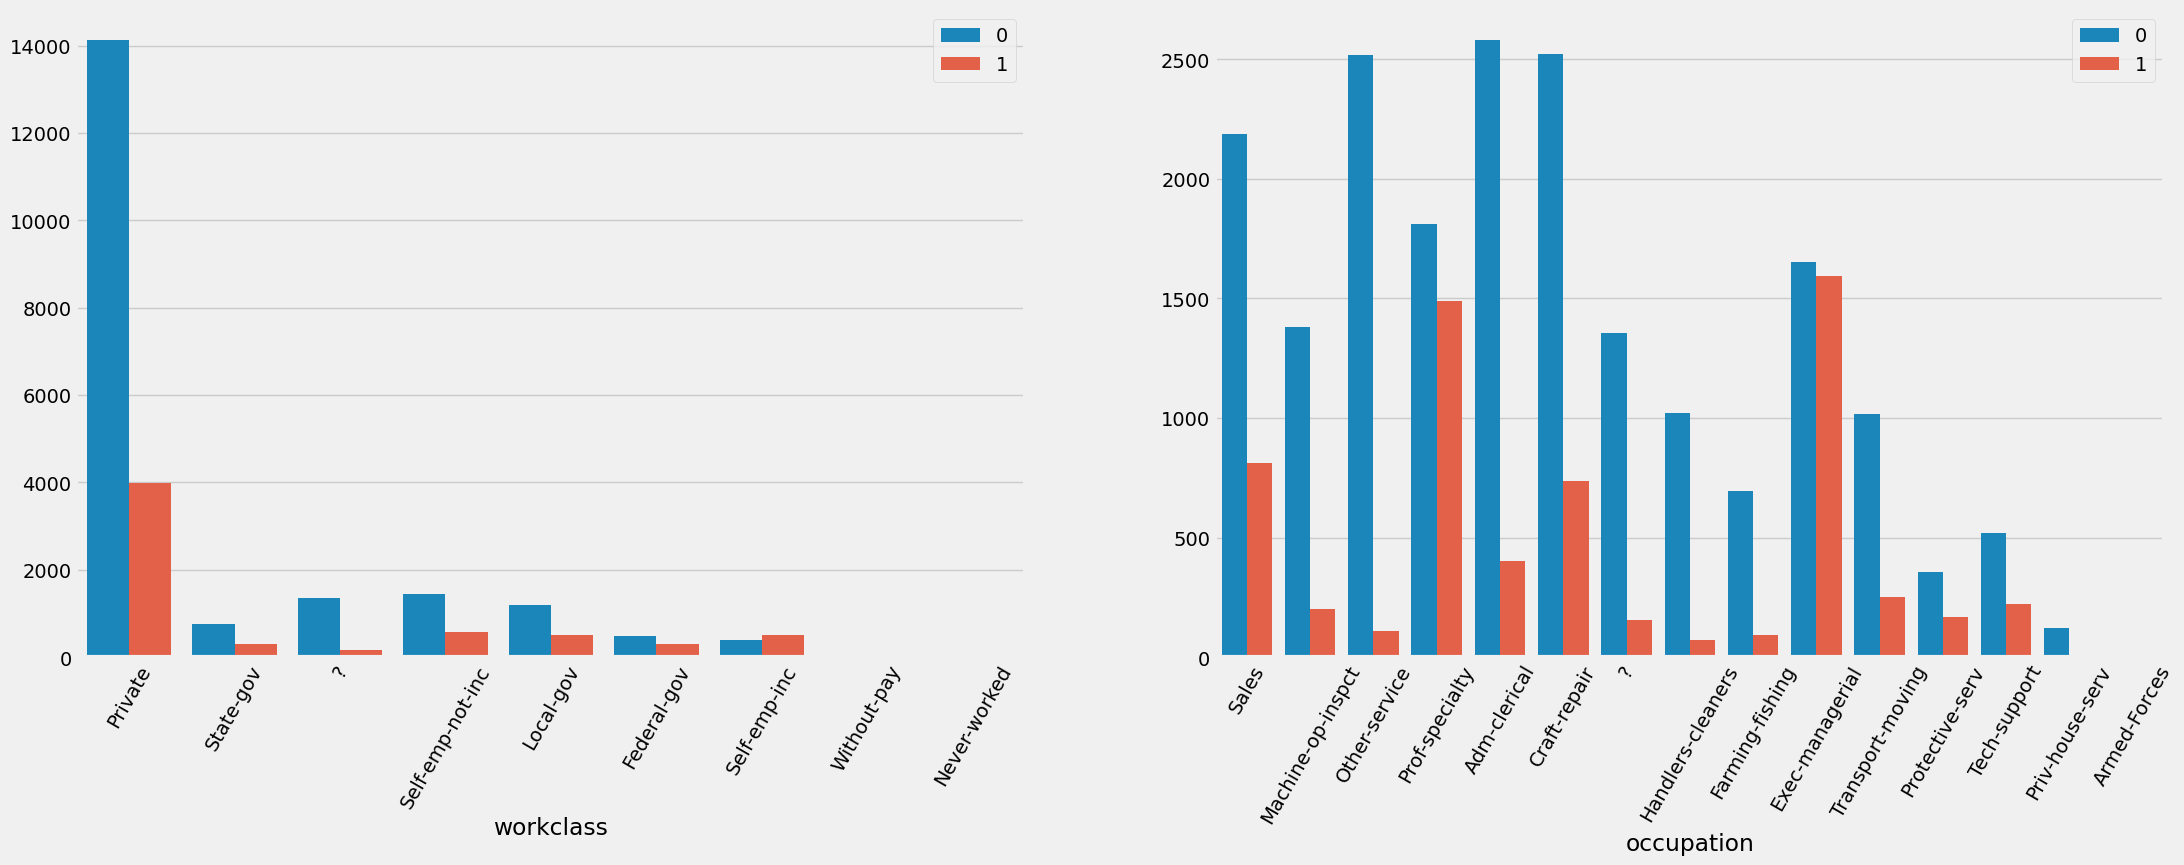

In [ ]:
# workclass와 occupation 데이터 분포 확인

fig, ax = plt.subplots(1, 2, figsize=(24, 8))

sns.countplot(x='workclass', hue='income', data=tmp_train, ax=ax[0])
ax[0].tick_params(axis='x', labelrotation=60)
ax[0].set_ylabel('')
ax[0].legend(loc='upper right')

sns.countplot(x='occupation', hue='income', data=tmp_train, ax=ax[1])
ax[1].tick_params(axis='x', labelrotation=60)
ax[1].set_ylabel('')
ax[1].legend(loc='upper right')

plt.show()

In [ ]:
# 두 변수 모두 '?' 값이 있는데 `occupation`에 6개가 더 많다.
# workclass 와 occupation의 '?'값을 가지는 데이터가 같은지 확인 => 같다.
train[(train['workclass'] == '?') & (train['occupation'] == '?')].shape[0] == train[train['workclass'] == '?'].shape[0]

True

In [ ]:
# workclass는 '?'가 아니지만 occupation만 '?'를 가지는 데이터 확인
train[(train['workclass'] != '?') & (train['occupation'] == '?')][['workclass', 'occupation']]

,workclass,occupation
7929,Never-worked,?
8698,Never-worked,?
13008,Never-worked,?
15076,Never-worked,?
17531,Never-worked,?
24153,Never-worked,?


### hours_per_week

* '?' 값과 관련지어봤다.

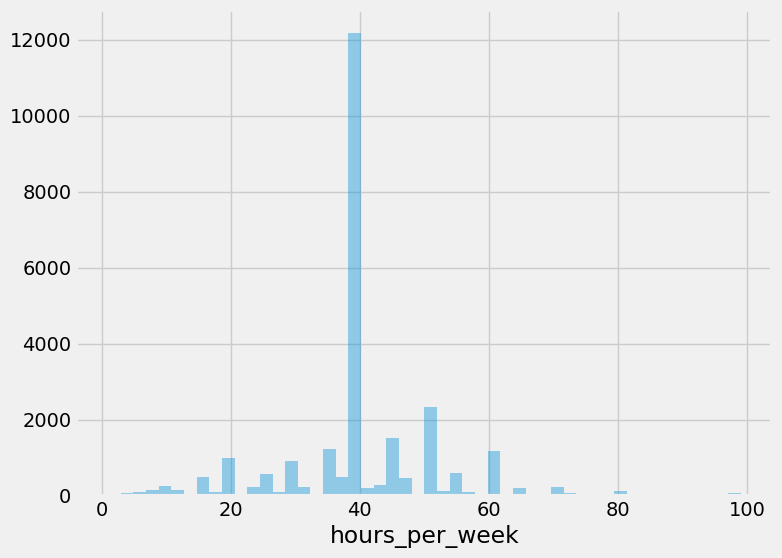

In [ ]:
sns.distplot(tmp_train['hours_per_week'], kde=False);

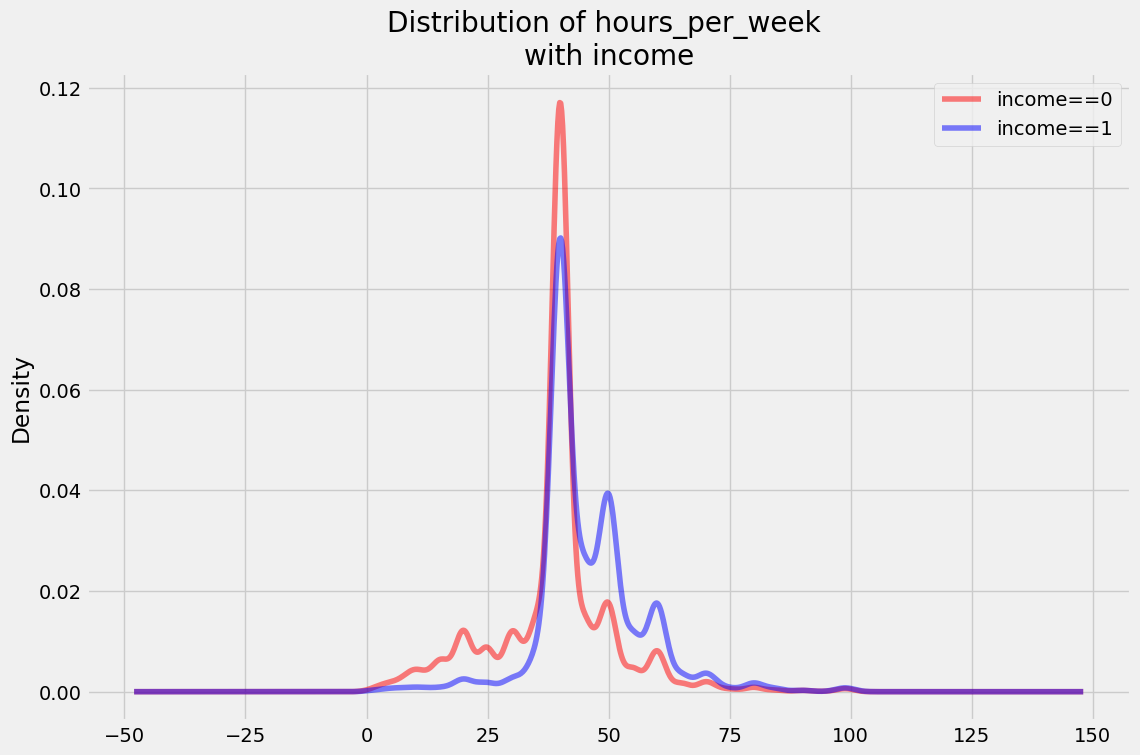

In [ ]:
# 수입(타겟)에 따른 분포 확인

plt.figure(figsize=(12, 8))

tmp_train[tmp_train['income'] == 0]['hours_per_week'].plot(kind='kde', alpha=0.5, color='red', label='income==0')
tmp_train[tmp_train['income'] == 1]['hours_per_week'].plot(kind='kde', alpha=0.5, color='blue', label='income==1')

plt.title('Distribution of hours_per_week \nwith income')
plt.legend()
plt.show()

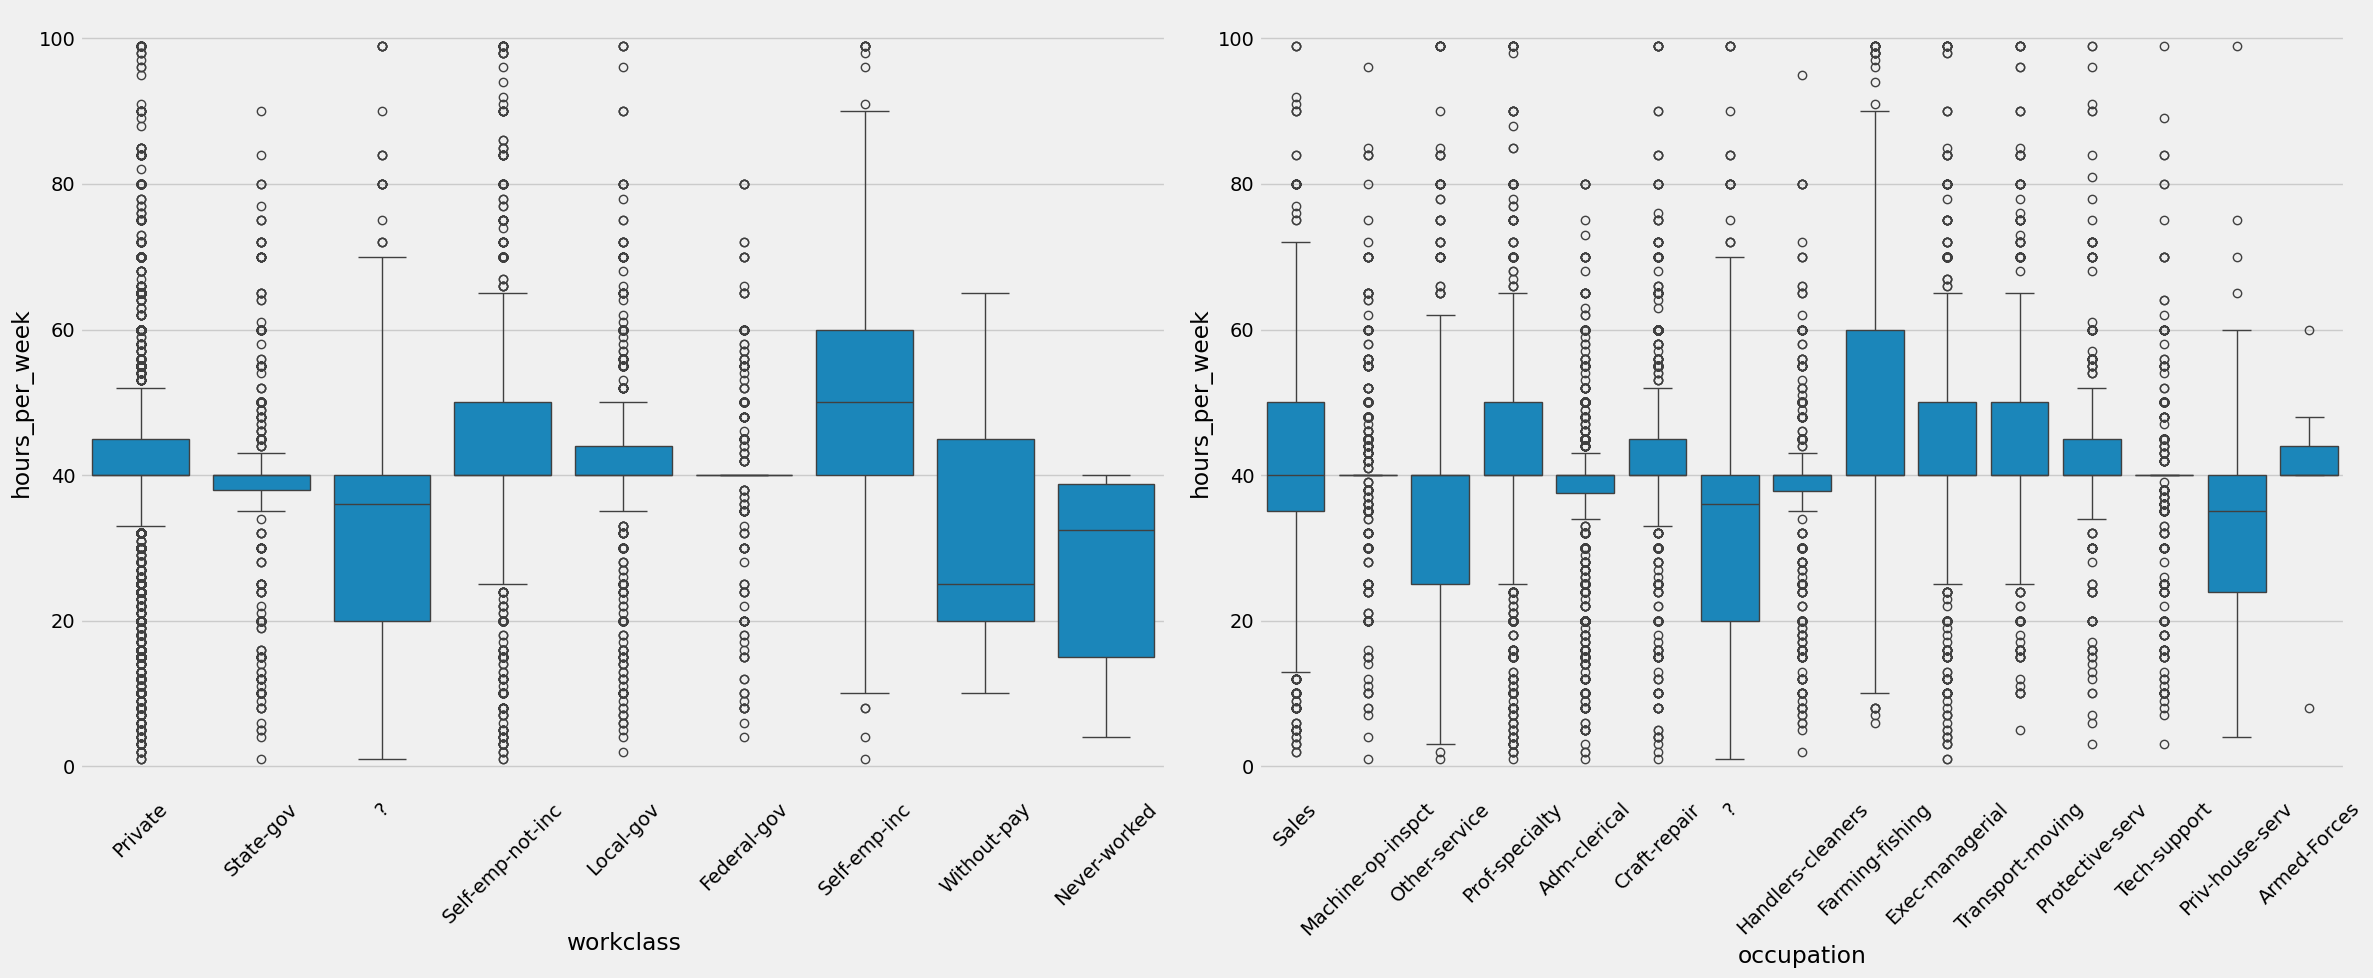

In [ ]:
# workclass 및 occupation과의 관계를 보기 위해 그려봄

# 그림의 크기 조정
fig, ax = plt.subplots(1, 2, figsize=(24, 10))

# 첫 번째 서브플롯 (workclass)
sns.boxplot(x='workclass', y='hours_per_week', data=tmp_train, ax=ax[0])
ax[0].tick_params(axis='x', labelrotation=45)  # x축 레이블 회전

# 두 번째 서브플롯 (occupation)
sns.boxplot(x='occupation', y='hours_per_week', data=tmp_train, ax=ax[1])
ax[1].tick_params(axis='x', labelrotation=45)  # x축 레이블 회전

plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()


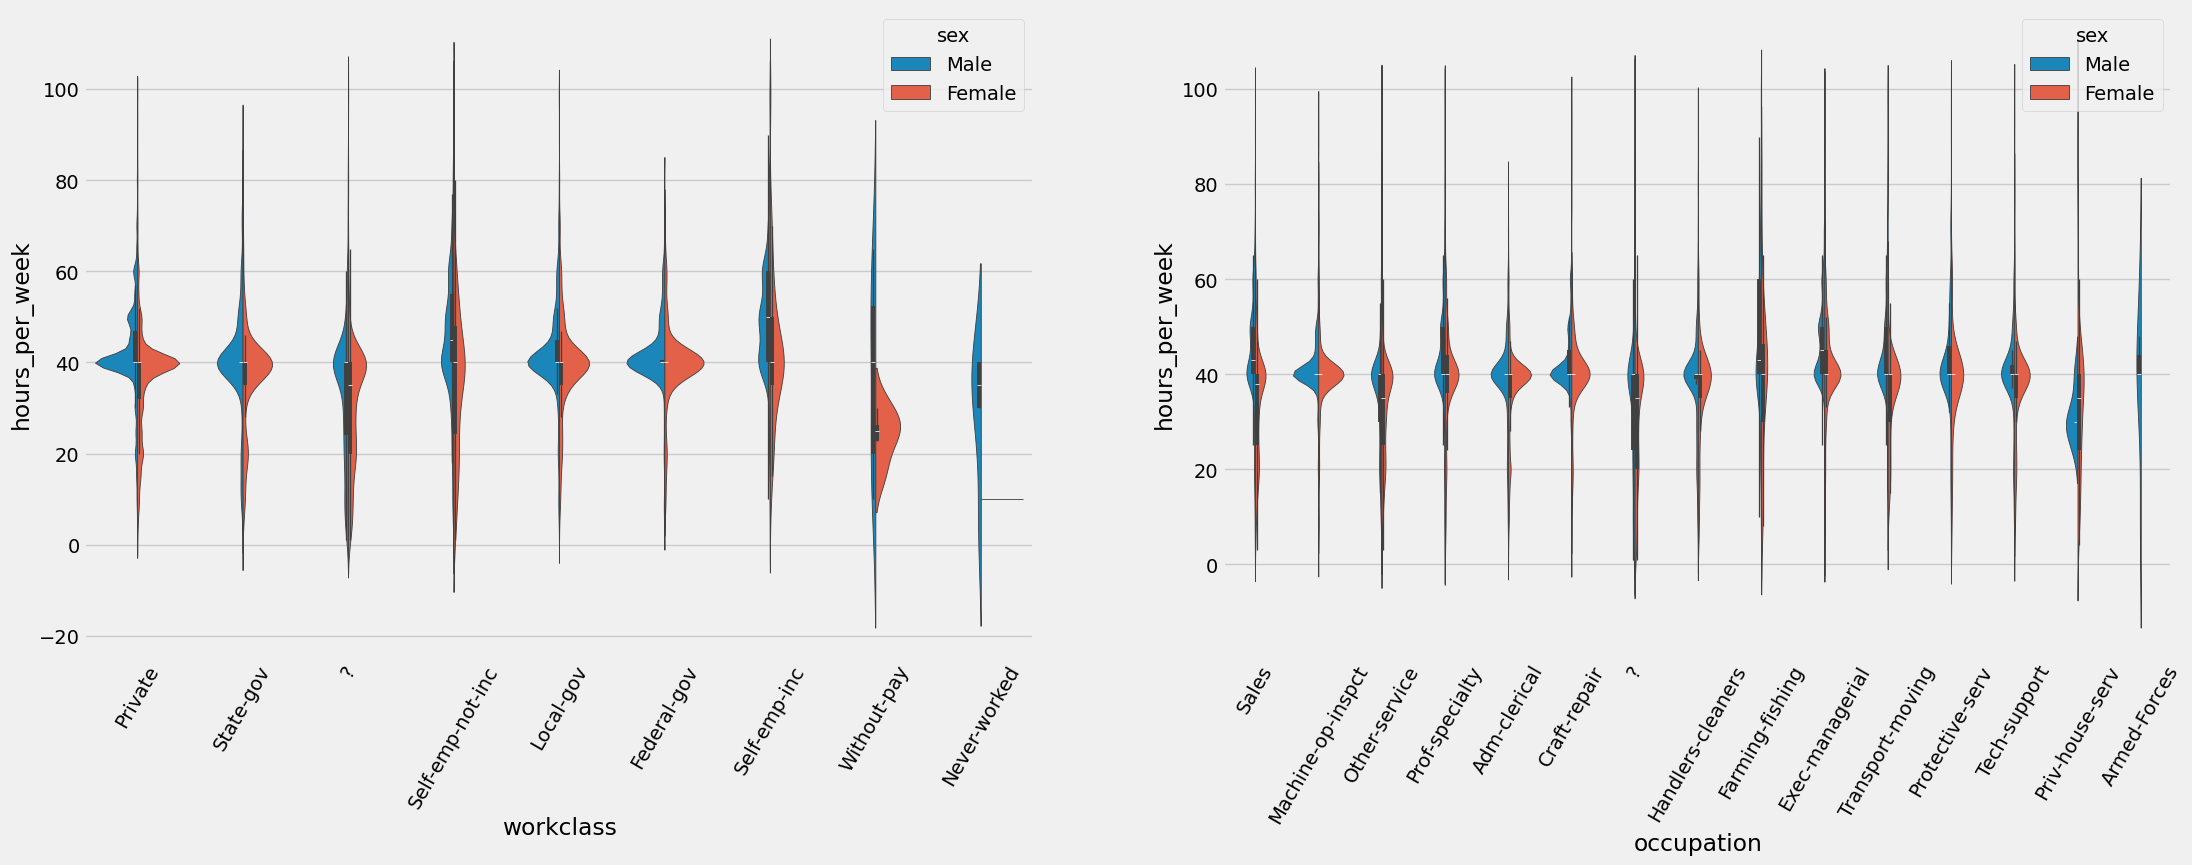

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

sns.violinplot(x='workclass', y='hours_per_week', hue='sex', data=tmp_train, split=True, ax=ax[0])
ax[0].tick_params(axis='x', labelrotation=60)

sns.violinplot(x='occupation', y='hours_per_week', hue='sex', data=tmp_train, split=True, ax=ax[1])
ax[1].tick_params(axis='x', labelrotation=60)

plt.show()

In [ ]:
# test set '?' 확인
for col in test.columns:
    if '?' in test[col].values:
        print(col)

workclass
occupation
native_country


### sex

* 별 다른 사항이 없어 그대로 사용했다.

In [ ]:
tmp_train['sex'].value_counts()

Male      17482
Female     8567
Name: sex, dtype: int64

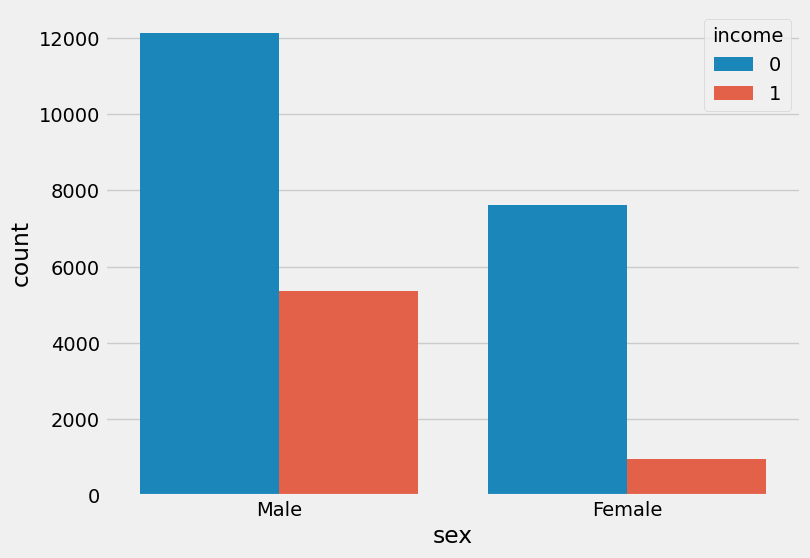

In [ ]:
sns.countplot(x='sex', hue='income', data=tmp_train);

# Feature Engineering


<적용 사항>
* `income`
* `age_band` 변수
* `education_num` 삭제
* `capital_log` 변수
* `native_country_bin` 변수


* LabelEncoding (Ordinal Encoding 이라는 개념이 있었는데 다음번에 적용해볼만 할 것 같다.) - `workclass`, `education`, `marital_status`, `occupation`, `relationship`, `race`


* Scaling - `fnlwgt`


* '?' 값 - `workclass`와 `occupation`의 6개의 값을 제외하고는 그대로 사용했다.

## train test 합치기

* 효율적인 Feature Engineering을 위함

In [ ]:
# Feature Engineering 이후 분리할 인덱스
idx = len(train)

# train과 test set 합쳐서 한번에 진행
df = pd.concat([train, test])

## 변수 값 적용

### age_band

In [ ]:
df = make_age_band(df)

### capital_log

In [ ]:
# test도 train에서 처럼 capital_gain과 capital_loss 값을 동시에 가지는 데이터가 없는지 확인 -> 없으니 그대로 진행
test[(test.capital_gain != 0) & (test.capital_loss != 0)]

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country


In [ ]:
# log값 구하기
df['capital_gain_log'] = df['capital_gain'].map(lambda x: np.log1p(x))
df['capital_loss_log'] = df['capital_loss'].map(lambda x: (-1) * np.log1p(x)) # loss는 음수로 처리

# capital_loss_log에는 음수 값으로 적용해준다
df['capital_log'] = df['capital_gain_log'] + df['capital_loss_log']

### native_country

In [ ]:
# native_country
df['native_country_bin'] = df['native_country'].map(lambda x: 1 if x == 'United-States' else 0)

### '?' 값 처리

In [ ]:
null_col = [col for col in df.columns if '?' in df[col].values]
print(null_col)

['workclass', 'occupation', 'native_country']


In [ ]:
for col in null_col:
    print(f"{col}: {len(df[df[col] == '?'][col])}")

workclass: 1836
occupation: 1843
native_country: 583


In [ ]:
# workclass는 '?'가 아니지만 occupation은 '?'인 값에 대해서 같은 값으로 변경해준다.
df[(df['workclass'] != '?') & (df['occupation'] == '?')]['occupation'] = 'Never-worked'

## Drop columns

In [ ]:
# 현재 columns 확인
df.columns

Index(['id', 'age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income', 'age_band', 'capital_gain_log', 'capital_loss_log',
       'capital_log', 'native_country_bin'],
      dtype='object')

In [ ]:
drop_col = ['id', 'age', 'education_num', 'capital_gain', 'capital_loss', 'native_country', 'capital_gain_log', 'capital_loss_log']

df = df.drop(columns=drop_col)

## Label Encoding

In [ ]:
label_col = [col for col in df.columns if df[col].dtypes == 'object' and col != 'income']
label_col.append('age_band')

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in label_col:
    df[col] = le.fit_transform(df[col])

In [ ]:
df.head()

,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,hours_per_week,income,age_band,capital_log,native_country_bin
0,4,168538,11,2,12,0,4,1,60,>50K,3,0.0,1
1,4,101626,6,4,7,3,4,1,20,<=50K,0,0.0,1
2,4,353358,15,4,8,3,4,1,16,<=50K,0,0.0,1
3,4,151158,15,4,10,3,4,0,25,<=50K,1,0.0,1
4,4,122234,15,4,1,1,2,0,20,<=50K,1,0.0,0


## Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['fnlwgt_scale'] = scaler.fit_transform(df['fnlwgt'].to_numpy().reshape(-1, 1))

In [ ]:
df = df.drop('fnlwgt', axis=1)

## train/test 분리

In [ ]:
train_fe = df.iloc[:idx, :]
test_fe = df.iloc[idx:, :].drop('income', axis=1)

## train income 변환

In [ ]:
train_fe['income'] = train_fe['income'].map(lambda x: 1 if x == '>50K' else 0)

## train valid split

* 결과적으론 GridSearch로 사용..

In [ ]:
from sklearn.model_selection import train_test_split

X = train_fe.drop('income', axis=1)
y = train_fe['income']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=seed)

# Modeling

In [ ]:
# 스코어 확인 함수
# python ML Guide 참고

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

## Random Forest & LightGBM

* default hyperparameters로 학습 후 score 측정
* 더 나은 모델에 대한 GridSearchCV 적용
* 후에 Stacking 적용

### Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_valid)
y_pred_proba = rf.predict_proba(X_valid)

rf_score = f1_score(y_valid, y_pred)
print("RF 기본 성능 확인 스코어: {:.4f}".format(rf_score))

RF 기본 성능 확인 스코어: 0.6650


In [ ]:
get_clf_eval(y_valid, y_pred, y_pred_proba[:, 1])

오차 행렬
[[4596  342]
 [ 620  955]]
정확도: 0.8523, 정밀도: 0.7363, 재현율: 0.6063, F1: 0.6650, AUC: 0.9022


### LightGBM

In [ ]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=seed)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_valid)
y_pred_proba_lgbm = lgbm.predict_proba(X_valid)[:, 1]

get_clf_eval(y_valid, y_pred_lgbm, y_pred_proba_lgbm)

[LightGBM] [Info] Number of positive: 4730, number of negative: 14806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 19536, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242117 -> initscore=-1.141107
[LightGBM] [Info] Start training from score -1.141107
오차 행렬
[[4660  278]
 [ 555 1020]]
정확도: 0.8721, 정밀도: 0.7858, 재현율: 0.6476, F1: 0.7101, AUC: 0.9307


### CatBoost

* Categorical variable이 많을 때 좋다고 하여 사용해봤다.

In [ ]:
cb = CatBoostClassifier(random_seed=seed, verbose=0)

cb.fit(X_train, y_train)
y_pred_cb = cb.predict(X_valid)
y_pred_proba_cb = cb.predict_proba(X_valid)[:, 1]

get_clf_eval(y_valid, y_pred_cb, y_pred_proba_cb)

오차 행렬
[[4663  275]
 [ 545 1030]]
정확도: 0.8741, 정밀도: 0.7893, 재현율: 0.6540, F1: 0.7153, AUC: 0.9323


###  LGBM 하이퍼 파라미터 튜닝 - GridSearchCV (0.87353)
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html (공식 문서 참조)

* `num_leaves`: 가장 메인 파라미터 (일반적으로 `num_leaves` = 2^(`max_depth`)로 깊이별 트리와 동일한 수의 잎을 얻을 수 있다. 실제로는 `num_leaves` < 2^(`max_depth`) 이렇게 두어야함. leaf-wise tree 이기 때문)
* `min_data_in_leaf`: overfitting 방지 매개변수. 최적값은 훈련 샘플 수와 num_leaves에 따라 다른데, 대규모 데이터에서 수백 ~ 수천으로 두면 충분하다.
* `max_depth`: 트리 깊이 조절


<정확도를 위한 변수>

* `max_bin`: 크게 적용(속도는 느려진다.)
* 작은 `learning_rate`, 큰 `num_iterations`
* 큰 `num_leaves` (overfitting이 일어날 수 있다.)
* 데이터 세트 늘리기
* `boosting_type` 을 dart(Dropouts meet Multiple Additive Regression Trees)로 적용 (defalt: 'gbdt'(gradient boosting decision tree))

In [ ]:
lgbm = LGBMClassifier(random_state=seed)

params = {
    'boosting_type': ['gbdt', 'dart'], # defalt 'gbdt'
    'num_leaves': [20, 31, 50, 70], # default 31
    'max_depth': [-1, 5, 7, 10, 15, 20, 30], # default -1. 끝까지 만드는 것
    'learning_rate': [0.001, 0.01, 0.05, 0.1], # defaut 0.1
}

lgbm_grid_cv = GridSearchCV(lgbm, param_grid=params, scoring='f1', n_jobs=-1, cv=5, verbose=1)
lgbm_grid_cv.fit(X, y)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[LightGBM] [Info] Number of positive: 6305, number of negative: 19744
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 26049, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242044 -> initscore=-1.141507
[LightGBM] [Info] Start training from score -1.141507


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=3), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1],
                         'max_depth': [-1, 5, 7, 10, 15, 20, 30],
                         'num_leaves': [20, 31, 50, 70]},
             scoring='f1', verbose=1)

In [ ]:
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(lgbm_grid_cv.best_score_))
print('GridSearchCv 최적 하이퍼 파라미터: ', lgbm_grid_cv.best_params_)

GridSearchCV 최고 평균 정확도 수치: 0.7077
GridSearchCv 최적 하이퍼 파라미터:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 50}


In [ ]:
best_lgbm = lgbm_grid_cv.best_estimator_
lgbm_pred = best_lgbm.predict(test_fe)

submission_lgbm = submission.copy()
submission_lgbm['prediction'] = lgbm_pred

submission_lgbm.to_csv('./lgbm_gridCV.csv', index=False)

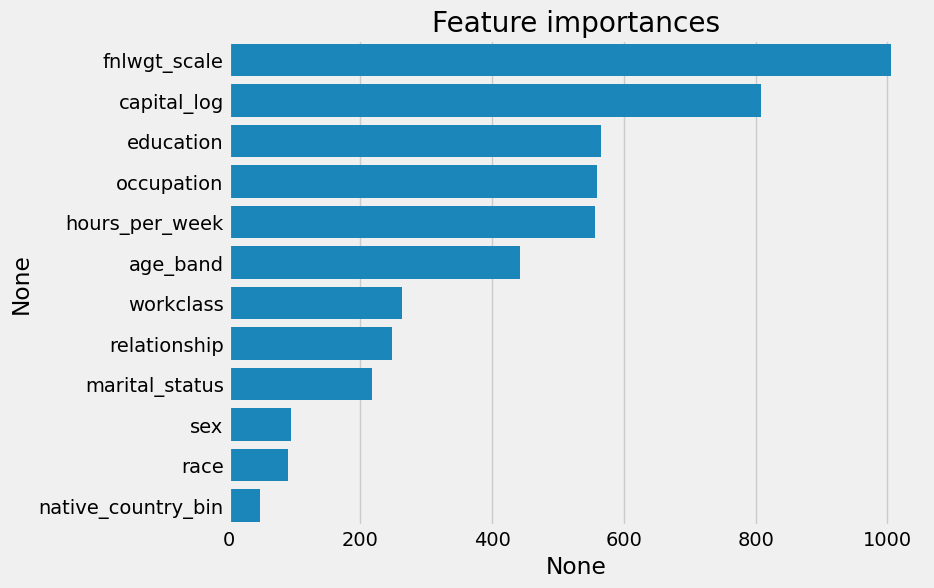

In [ ]:
ftr_importances_values = best_lgbm.feature_importances_

# Top 중요도로 정렬을 쉽게 하고, Seaborn의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index=X.columns)

# 중요도 값 순으로 Series를 정렬
ftr_top = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=ftr_top, y=ftr_top.index, orient='h')
plt.title('Feature importances')
plt.show()